In [34]:
## this notebook explains testing whether events are on ridges,
## extracting important parameters like lifetimes, categories, etc,
## and making interpolated or renormalized plots of CCPs

In [2]:
# enables autoloading from updated functions in external libraries or scripts (to prevent complete )
%load_ext autoreload
%autoreload 2
# put plots in between cells
%matplotlib inline
# enable widgets from terminal (specified by !)
!jupyter nbextension enable --py widgetsnbextension

# import all necessary libraries

import os # folder and their item navigation and bookkeeping
import matplotlib.pyplot as plt # all things plotting
import sys # allows us to cue the notebook to look for external Python scripts 
from ipywidgets import interact, interactive, fixed, interact_manual # for interactive widgets
import ipywidgets as widgets
import itk # for image (tiff) loading
import numpy as np # manipulating array-like structures
import pickle # for saving data structures
import csv # for loading comma-delimited text files
import cv2 # for loading images and image processing
from tqdm import tqdm
import itertools
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset # for plot decoration
# allow lots of figures
plt.rcParams.update({'figure.max_open_warning': 0})
# the Python scripts added to the local path
sys.path.append(os.path.abspath(os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'))
source_code = os.getcwd()+'/cmeAnalysisPostProcessingPythonScripts/'

# custom Python scripts for this analysis

from nanopillar_detection import (hough_detection, 
                                  createLineIterator, 
                                  create_mask_from_hough_lines, 
                                  load_itk_image,
                                  test_on_pillar,
                                  format_image_hough_detection,
                                  return_puncta_relative_to_pillar,
                                  modify_filename,
                                  create_grid_display_nanopillars)
from display_tracks import (load_tracks, load_tracks_no_sort, display_tracks,
                            remove_tracks_by_criteria, 
                            select_tracks_by_indices,
                            remove_tracks_by_indices,
                            load_itk_image,
                            plot_separated_cohorts)
import return_track_attributes
import generate_index_dictionary
index_dictionary = generate_index_dictionary.return_index_dictionary()

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [35]:
def test_on_pillar_loop(track_x,
                        track_y,
                        mask_x,
                        mask_y,
                        tolerance=1, 
                        min_frames=1):
    
    """ Check if a puncta coordinate is on a mask pixel within a defined tolerance distance"""

#     nonzero_mask_positions = np.nonzero(mask_positions)
#     B = nonzero_mask_positions[0]
#     A = nonzero_mask_positions[1]
    
    count_on_pillar = 0 # how many times the track runs into a pillar
    distance_associated = [] # the distances from the pillar pixel for each instance that we are "near" the pillar

    for i in range(len(track_x)): # iterate through every frame of the current track

        X = np.sqrt( np.square( mask_x - track_x[i] ) +  np.square( mask_y - track_y[i] ) ) # find the distance between the track (x,y) and every mask==1 position
        idx = np.where( X == X.min() ) # find the index in the distance differences from the line above

        if (X[idx]<tolerance).any(): # if we're ever close to the mask..
            count_on_pillar+=1 # count it
            distance_associated.append(X[idx])

    if count_on_pillar>=min_frames: # make sure we are near the pillar for this track for a minimum number of movie frames
        return 1, distance_associated, count_on_pillar
    else:
        return 0, distance_associated, count_on_pillar

In [36]:
def filter_for_ccps(tracks_to_check,
                    minimum_dnm2_counts=3,
                    sig_pval_cutoff=0.01,
                    minimum_lifetime=18,
                    maximum_lifetime=180,
                    initial_msd_threshold=0.02,
                    pixel_size=0.108,
                    mask_for_substrate=[],
                    pixel_tolerance=1,
                    substrate_frame_overlap=5):
    
    """return tracks that are sufficiently DNM2 rich, not too long or not too short, and aren't too speedy"""
    
    tracks_kept = [] # the CCPs we're keeping
    tracks_discarded = []

    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:

        # and make sure track is category 1 (valids with good gaps)
        track_lifetime = return_track_attributes.return_track_lifetime(tracks_to_check, i)

        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][1]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]

        max_dnm2_repeats = max_1s
    
        initial_msd = tracks_to_check[i][index_dictionary['index_MotionAnalysis']][0][0][1][0][0]
        
        initial_msd = pixel_size**2 * initial_msd
            
        if mask_for_substrate != []:
            
            mask = mask_for_substrate
            mask_nonzero = np.nonzero(mask) # the mask of interest's nonzero positions (where the pillar pixels are)
            mask_x = mask_nonzero[0] # the x positions
            mask_y = mask_nonzero[1] # the y positions
            
            track_x = return_track_attributes.return_track_x_position(tracks_to_check, i)[0] # x and y positions for every frame of the track (not including buffer)
        
            track_y = return_track_attributes.return_track_y_position(tracks_to_check, i)[0]
        
            pillar_test= test_on_pillar_loop(track_x,
                                             track_y,
                                             mask_x,
                                             mask_y,
                                             pixel_tolerance, # 1 pixel tolerance for belonging to a pixel-neighbor
                                             substrate_frame_overlap) # be associated with mask for at least 5 FRAMES 
            
            if track_lifetime >= minimum_lifetime and \
               track_lifetime <= maximum_lifetime and \
               max_dnm2_repeats >= minimum_dnm2_counts and \
               initial_msd <= initial_msd_threshold and \
               pillar_test[0] == 1:
                
                tracks_kept.append(tracks_to_check[i])
            else:
                tracks_discarded.append(tracks_to_check[i])
                
        elif track_lifetime >= minimum_lifetime and \
           track_lifetime <= maximum_lifetime and \
           max_dnm2_repeats >= minimum_dnm2_counts and \
           initial_msd <= initial_msd_threshold:
            
            
            tracks_kept.append(tracks_to_check[i])
        else:
            tracks_discarded.append(tracks_to_check[i])
    return tracks_kept, tracks_discarded

In [37]:
##tests for sufficient dynamin2 recruitment to be a valid track
def filter_for_dnm2(tracks_to_check,
                    minimum_dnm2_counts=3,
                    sig_pval_cutoff=0.01,
                    minimum_lifetime=18,
                    maximum_lifetime=280,
                    pixel_size=0.108):
    
    """return tracks that are sufficiently DNM2 rich, not too long or not too short, and aren't too speedy"""
    
    tracks_kept = [] # the CCPs we're keeping
    tracks_discarded = []

    for i in tqdm(range(len(tracks_to_check))): # iterate through all tracks
        # iterate through tracks that satisfy a condition:

        # and make sure track is category 1 (valids with good gaps)
        track_lifetime = return_track_attributes.return_track_lifetime(tracks_to_check, i)

        pvals = tracks_to_check[i][index_dictionary['index_pval_Ar']][1]
        significant_pval_indices = [1 if pval < sig_pval_cutoff else 0 for pval in pvals]
        repeated_indices = [(x[0], len(list(x[1]))) for x in itertools.groupby(significant_pval_indices)]
        max_1s = 0
        for itm in repeated_indices:
            if itm[0] == 1:
                if itm[1]>max_1s:
                    max_1s=itm[1]

        max_dnm2_repeats = max_1s

            
        if track_lifetime >= minimum_lifetime and \
            track_lifetime <= maximum_lifetime and \
            max_dnm2_repeats >= minimum_dnm2_counts:
                
                tracks_kept.append(tracks_to_check[i])
        else:
                tracks_discarded.append(tracks_to_check[i])
    return tracks_kept, tracks_discarded

In [6]:
import pandas as pd
import seaborn as sns
import scipy.interpolate as interpolate

In [21]:
##for cells with mask
#load mask

mask = np.load('/Users/robertcail/Desktop/JCB_final/code/sample data/cmeAnalysis_tracksonridges/120nm/mask_MDA_dnm2GFP_AP2RFP.npy')

#load matlab file from cmeAnalysis

tracks = load_tracks('/Users/robertcail/Desktop/JCB_final/code/sample data/cmeAnalysis_tracksonridges/120nm/Ch1/Tracking/ProcessedTracks.mat')

#extract valid (type 1) detections

valid_tracks = remove_tracks_by_criteria(tracks, track_category=[1], number_of_channels=2)

#filter for CCPs and test whether they're on ridges

filtered_kept, filtered_discarded = filter_for_ccps(valid_tracks, mask_for_substrate = mask, substrate_frame_overlap=1)

  0%|          | 1/6304 [00:00<14:30,  7.24it/s]

The number of tracks returned: 6304



100%|██████████| 6304/6304 [01:13<00:00, 85.34it/s] 


In [24]:
##for flat cells
#load matlab file from cmeAnalysis (especially for flat)
flat_tracks_1 = load_tracks('/Users/robertcail/Desktop/JCB_final/code/sample data/cmeAnalysis_tracksonridges/flat/Ch1/Tracking/ProcessedTracks.mat')

#filter for valid category 1 tracks
flat_valids_1 = remove_tracks_by_criteria(flat_tracks_1, track_category=[1], number_of_channels=2)

#filter for CCPs (low MSD, correct lifetime)
flat_CCPs_1 = filter_for_ccps(flat_valids_1, pixel_size=0.108)[0]


 30%|███       | 2852/9472 [00:00<00:00, 28451.45it/s]

The number of tracks returned: 9472



100%|██████████| 9472/9472 [00:00<00:00, 43079.00it/s]


In [40]:
#extract CCP lifetimes, simply change all_tracks to name of filtered track list
lifetimes = []
for i in range(len(flat_CCPs_1)):
    lifetime_temp = return_track_attributes.return_track_lifetime(flat_CCPs_1, i)
    lifetimes.append(lifetime_temp)
min_lifetime = np.min(lifetimes)
max_lifetime = np.max(lifetimes)
## turn on next line to print all lifetimes for analysis
#print(lifetimes)


In [28]:
##function to plot un-normalized tracks

def plot_separated_cohorts_interpolated(axes,
                                        vectors,
                                        cohort_bounds,
                                        colors,
                                        channel_for_normalization=0,
                                        framerate=1):
    num_in_cohorts = []
    num_ticks = 0
    x_labels = []
    for cohort in cohort_bounds:
        x_labels+=list(range(0,cohort[1]-10+1,10))
        num_ticks += int(cohort[1]/10)+1
    offsets = []
    cohort_samples = cohort_bounds.copy()
    cohort_samples[-1] = [cohort_samples[-1][0], cohort_samples[-1][1]+1]
    for i in range(len(cohort_samples)):
        if i==0:
            offsets.append(0)
        else:
            offsets.append(cohort_samples[i][0])
        if i > 0:
            offsets[i]+=offsets[i-1]
#     print(offsets)
#     offsets[-1]+=-1
#     print(offsets)
    num_stds = 0.25
#     cohort_bounds[-1][1] = cohort_bounds[-1][1]-1
    for i in range(1,len(offsets)):
        plt.axvline(offsets[i], 0, 1, linestyle='--', color='black', alpha=0.9)
    vectors_to_plot = []
    for cluster_amplitudes in vectors:
        num_per_cond = []
        amplitudes = np.array(cluster_amplitudes, dtype='object')
#         print(amplitudes.shape)
        cluster_amplitudes_temp = []
        for cohort in cohort_samples:
            cohort_temp_class = []
            for i in range(len(amplitudes)):
                lifetime = len(amplitudes[i][0])*framerate
                if lifetime >= cohort[0] and lifetime < cohort[1]:
                    cohort_channels = []
#                     print('test')
#                     print(np.array(amplitudes[i]))
#                     print(np.array(amplitudes[i]).shape)
                    for ch in range(np.array(amplitudes[i]).shape[0]):
#                         print(amplitudes[i])
                        t, c, k = interpolate.splrep(np.arange(len(amplitudes[i][ch])), amplitudes[i][ch], k=3)
                        spline = interpolate.BSpline(t, c, k, extrapolate=False)
                        splined_amp = spline(np.linspace(0, len(amplitudes[i][ch]), cohort[1]))
                        cohort_channels.append(splined_amp)
                    cohort_temp_class.append(cohort_channels)
            num_per_cond.append(len(cohort_temp_class))
            cluster_amplitudes_temp.append(cohort_temp_class)
        vectors_to_plot.append(cluster_amplitudes_temp)
        num_in_cohorts.append(num_per_cond)
#     print(np.array(vectors_to_plot).shape)
#     print(len(vectors_to_plot))
    for cluster_num in range(len(vectors_to_plot)):
        means_to_plot = []
        stds_to_plot = []
        max_vals = []
        for cohort_num in range(len(vectors_to_plot[cluster_num])):
            cohort_cluster_amps = np.array(vectors_to_plot[cluster_num][cohort_num])
            means_to_plot.append(np.nan_to_num(np.nanmean(cohort_cluster_amps,axis=0,dtype=np.float64))) # calculate average and std of intensity in class cohort
            stds_to_plot.append(num_stds*np.nan_to_num(np.nanstd(cohort_cluster_amps,axis=0,dtype=np.float64)))
#             print('test')
#             print(means_to_plot[-1].shape)
            max_vals.append(np.max(means_to_plot[-1][channel_for_normalization]))
        max_val = np.max(max_vals)
        print('Max_val is' , max_vals)
        for cohort_num in range(len(vectors_to_plot[cluster_num])):
            x_axis = np.linspace(offsets[cohort_num],
                                 offsets[cohort_num]+len(means_to_plot[cohort_num][0]),
                                 len(means_to_plot[cohort_num][0]))
#             print(len(x_axis))
            avg_intensities_scaled = 1/max_val*means_to_plot[cohort_num]
            std_intensities_scaled = 1/max_val*stds_to_plot[cohort_num]
            for ch in range(np.array(avg_intensities_scaled).shape[0]):
#                 print(len(avg_intensities_scaled[ch]))
                axes.plot(x_axis,
                          avg_intensities_scaled[ch],
                          color=colors[cluster_num][ch])
                axes.fill_between(x_axis,
                                 avg_intensities_scaled[ch]-std_intensities_scaled[ch],
                                 avg_intensities_scaled[ch]+std_intensities_scaled[ch],
                                 color=colors[cluster_num][ch],
                                 alpha=0.2)
    return num_in_cohorts, offsets

In [29]:
##pass in values for normalization, so you can compare intensity across treatments
def plot_separated_cohorts_renormalized(axes,
                                        vectors,
                                        cohort_bounds,
                                        colors,
                                        vals_for_normalization,
                                        framerate=1):
    num_in_cohorts = []
    num_ticks = 0
    x_labels = []
    for cohort in cohort_bounds:
        x_labels+=list(range(0,cohort[1]-10+1,10))
        num_ticks += int(cohort[1]/10)+1
    offsets = []
    cohort_samples = cohort_bounds.copy()
    cohort_samples[-1] = [cohort_samples[-1][0], cohort_samples[-1][1]+1]
    for i in range(len(cohort_samples)):
        if i==0:
            offsets.append(0)
        else:
            offsets.append(cohort_samples[i][0])
        if i > 0:
            offsets[i]+=offsets[i-1]
#     print(offsets)
#     offsets[-1]+=-1
#     print(offsets)
    num_stds = 0.25
#     cohort_bounds[-1][1] = cohort_bounds[-1][1]-1
    for i in range(1,len(offsets)):
        plt.axvline(offsets[i], 0, 1, linestyle='--', color='black', alpha=0.9)
    vectors_to_plot = []
    for cluster_amplitudes in vectors:
        num_per_cond = []
        amplitudes = np.array(cluster_amplitudes, dtype='object')
#         print(amplitudes.shape)
        cluster_amplitudes_temp = []
        for cohort in cohort_samples:
            cohort_temp_class = []
            for i in range(len(amplitudes)):
                lifetime = len(amplitudes[i][0])*framerate
                if lifetime >= cohort[0] and lifetime < cohort[1]:
                    cohort_channels = []
#                     print('test')
#                     print(np.array(amplitudes[i]))
#                     print(np.array(amplitudes[i]).shape)
                    for ch in range(np.array(amplitudes[i]).shape[0]):
#                         print(amplitudes[i])
                        t, c, k = interpolate.splrep(np.arange(len(amplitudes[i][ch])), amplitudes[i][ch], k=3)
                        spline = interpolate.BSpline(t, c, k, extrapolate=False)
                        splined_amp = spline(np.linspace(0, len(amplitudes[i][ch]), cohort[1]))
                        cohort_channels.append(splined_amp)
                    cohort_temp_class.append(cohort_channels)
            num_per_cond.append(len(cohort_temp_class))
            cluster_amplitudes_temp.append(cohort_temp_class)
        vectors_to_plot.append(cluster_amplitudes_temp)
        num_in_cohorts.append(num_per_cond)
#     print(np.array(vectors_to_plot).shape)
#     print(len(vectors_to_plot))
    for cluster_num in range(len(vectors_to_plot)):
        means_to_plot = []
        stds_to_plot = []
       # max_vals = []
        for cohort_num in range(len(vectors_to_plot[cluster_num])):
            cohort_cluster_amps = np.array(vectors_to_plot[cluster_num][cohort_num])
            means_to_plot.append(np.nan_to_num(np.nanmean(cohort_cluster_amps,axis=0,dtype=np.float64))) # calculate average and std of intensity in class cohort
            stds_to_plot.append(num_stds*np.nan_to_num(np.nanstd(cohort_cluster_amps,axis=0,dtype=np.float64)))
#             print('test')
#             print(means_to_plot[-1].shape)
            #max_vals.append(np.max(means_to_plot[-1][channel_for_normalization]))
       # max_val = np.max(max_vals)
       # print('Max_val is' , max_vals)
        for cohort_num in range(len(vectors_to_plot[cluster_num])):
            x_axis = np.linspace(offsets[cohort_num],
                                 offsets[cohort_num]+len(means_to_plot[cohort_num][0]),
                                 len(means_to_plot[cohort_num][0]))
#             print(len(x_axis))
            avg_intensities_scaled = 1/vals_for_normalization*means_to_plot[cohort_num]
            std_intensities_scaled = 1/vals_for_normalization*stds_to_plot[cohort_num]
            for ch in range(np.array(avg_intensities_scaled).shape[0]):
#                 print(len(avg_intensities_scaled[ch]))
                axes.plot(x_axis,
                          avg_intensities_scaled[ch],
                          color=colors[cluster_num][ch])
                axes.fill_between(x_axis,
                                 avg_intensities_scaled[ch]-std_intensities_scaled[ch],
                                 avg_intensities_scaled[ch]+std_intensities_scaled[ch],
                                 color=colors[cluster_num][ch],
                                 alpha=0.2)
    return num_in_cohorts, offsets

In [30]:
cohorts = [[18,40], [40,60],[60,80],[80,180]]

In [31]:
tracks_to_plot = flat_CCPs_1

channel_amplitudes_cont_1 = []
for i in range(len(tracks_to_plot)):
    # get the first, second (or more) channel amps
    ap2_intensity = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_to_plot, i, 0)
    dnm2_intensity = return_track_attributes.return_track_amplitude_no_buffer_channel(tracks_to_plot, i, 1)
    channel_amplitudes_cont_1.append([ap2_intensity, dnm2_intensity])

Mean of empty slice
Degrees of freedom <= 0 for slice.


Max_val is [236.05573271642157, 299.1766491363734, 333.84276706177656, 351.7506105313033]


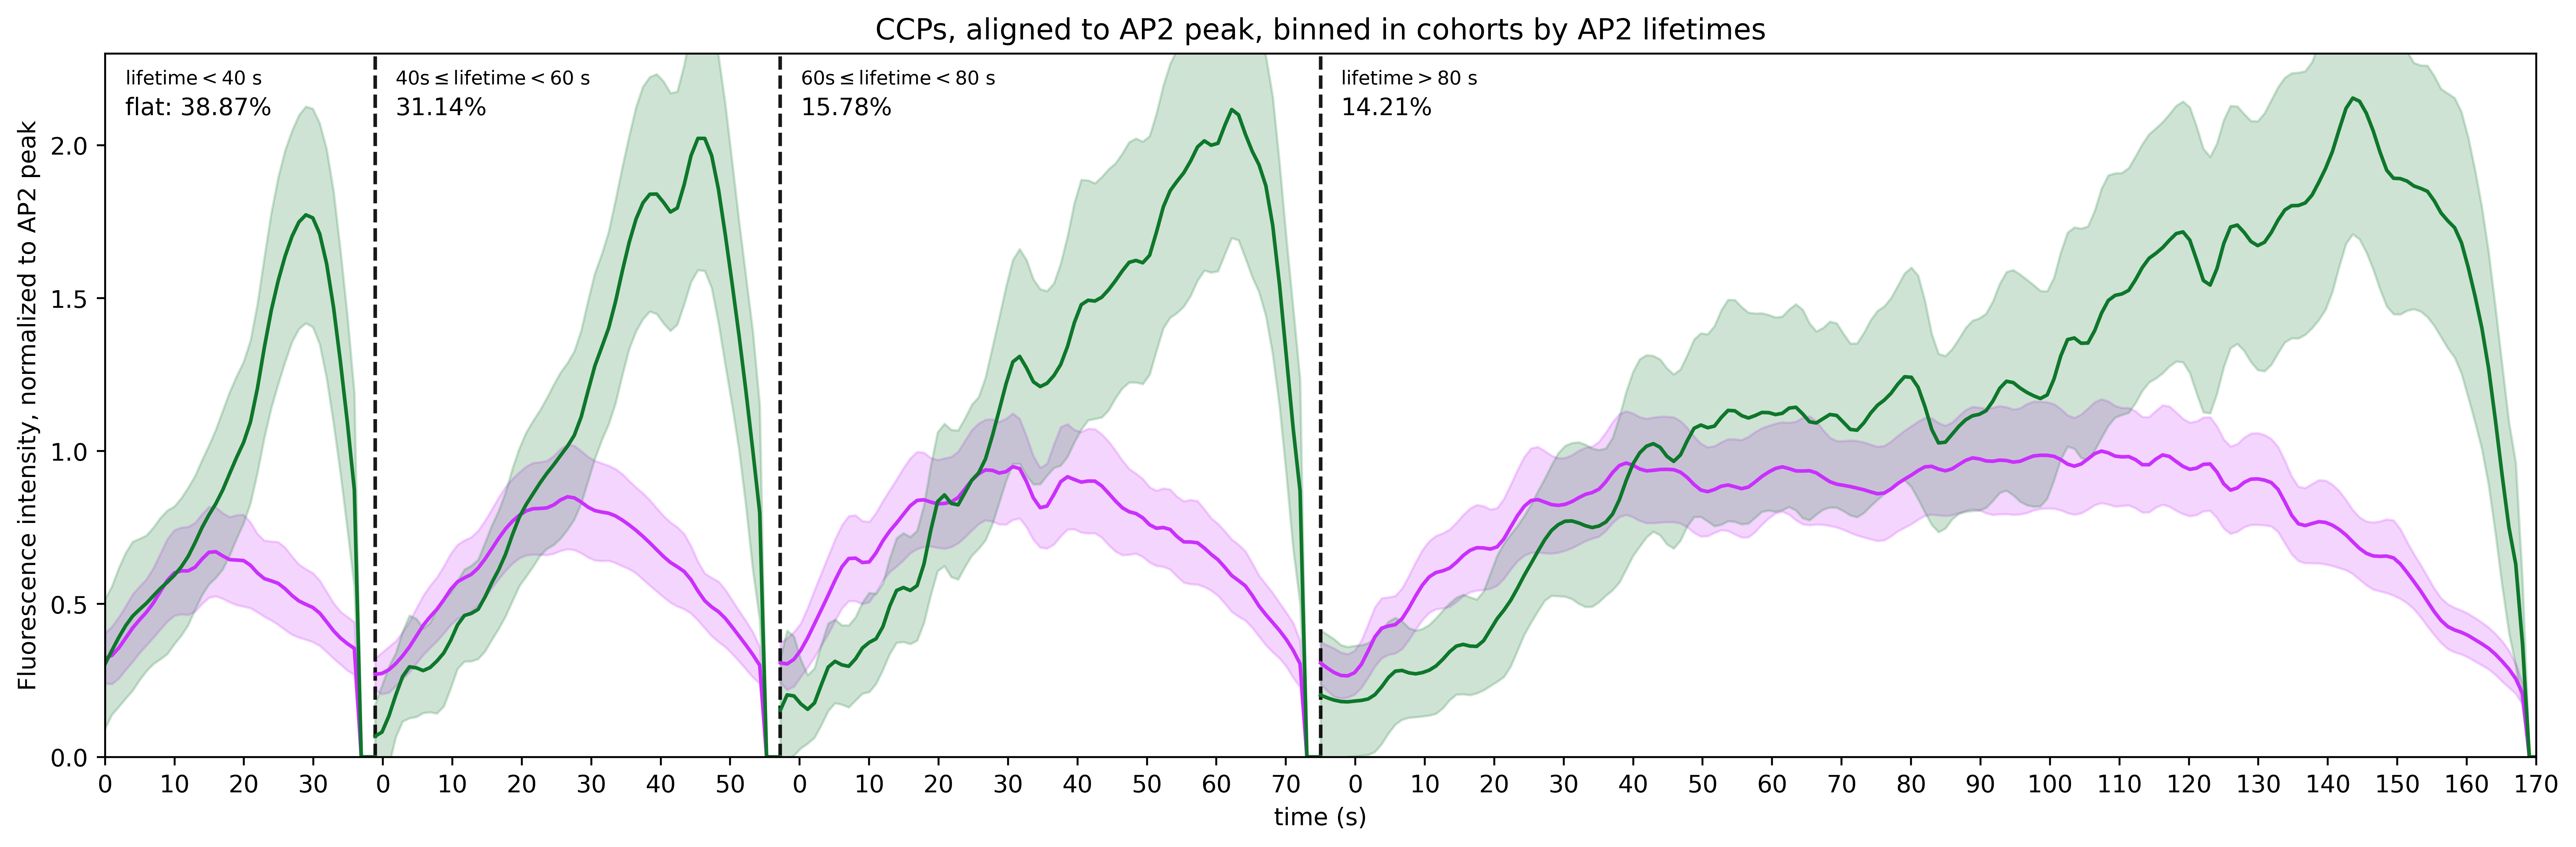

In [32]:
fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))

num_in_cohorts, offsets = plot_separated_cohorts_interpolated(axes,
                                    [channel_amplitudes_cont_1],
                                    cohorts,
                                    [['#CA30FC', '#0E772B']],
                                    channel_for_normalization=0,                          
                                    framerate=2)

text_horizontal_shifts = 3
text_percentage_y = 2.1
text_bounds_y = 2.2

labels_for_sizes = ['flat: ']
for shift_idx, num_in_cohort in enumerate(num_in_cohorts):
    for i in range(len(cohorts)):
        if i==0:
            if shift_idx==0:
                axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
            axes.text(text_horizontal_shifts, text_percentage_y-shift_idx*0.1, labels_for_sizes[shift_idx] + "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
        elif i==len(cohorts)-1:
            if shift_idx==0:
                axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
            axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y-shift_idx*0.1, "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
        else:
            if shift_idx==0:
                axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
            axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y-shift_idx*0.1, "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
            
x_labels = []
num_ticks = 0
for cohort in cohorts:
    x_labels+=list(range(0,cohort[1]-10+1,10))
    num_ticks += int(cohort[1]/10)+1
axes.set_xticks(np.linspace(0,360,len(x_labels)), minor=False)
axes.set_xticklabels(x_labels, minor=False)
axes.set_xlabel('time (s)')
axes.set_ylabel('Fluorescence intensity, normalized to AP2 peak')
axes.set_title('CCPs, aligned to AP2 peak, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])
axes.set_ylim([0,2.3])
plt.tight_layout()

#plt.savefig('insert desired save name here')            



Mean of empty slice
Degrees of freedom <= 0 for slice.


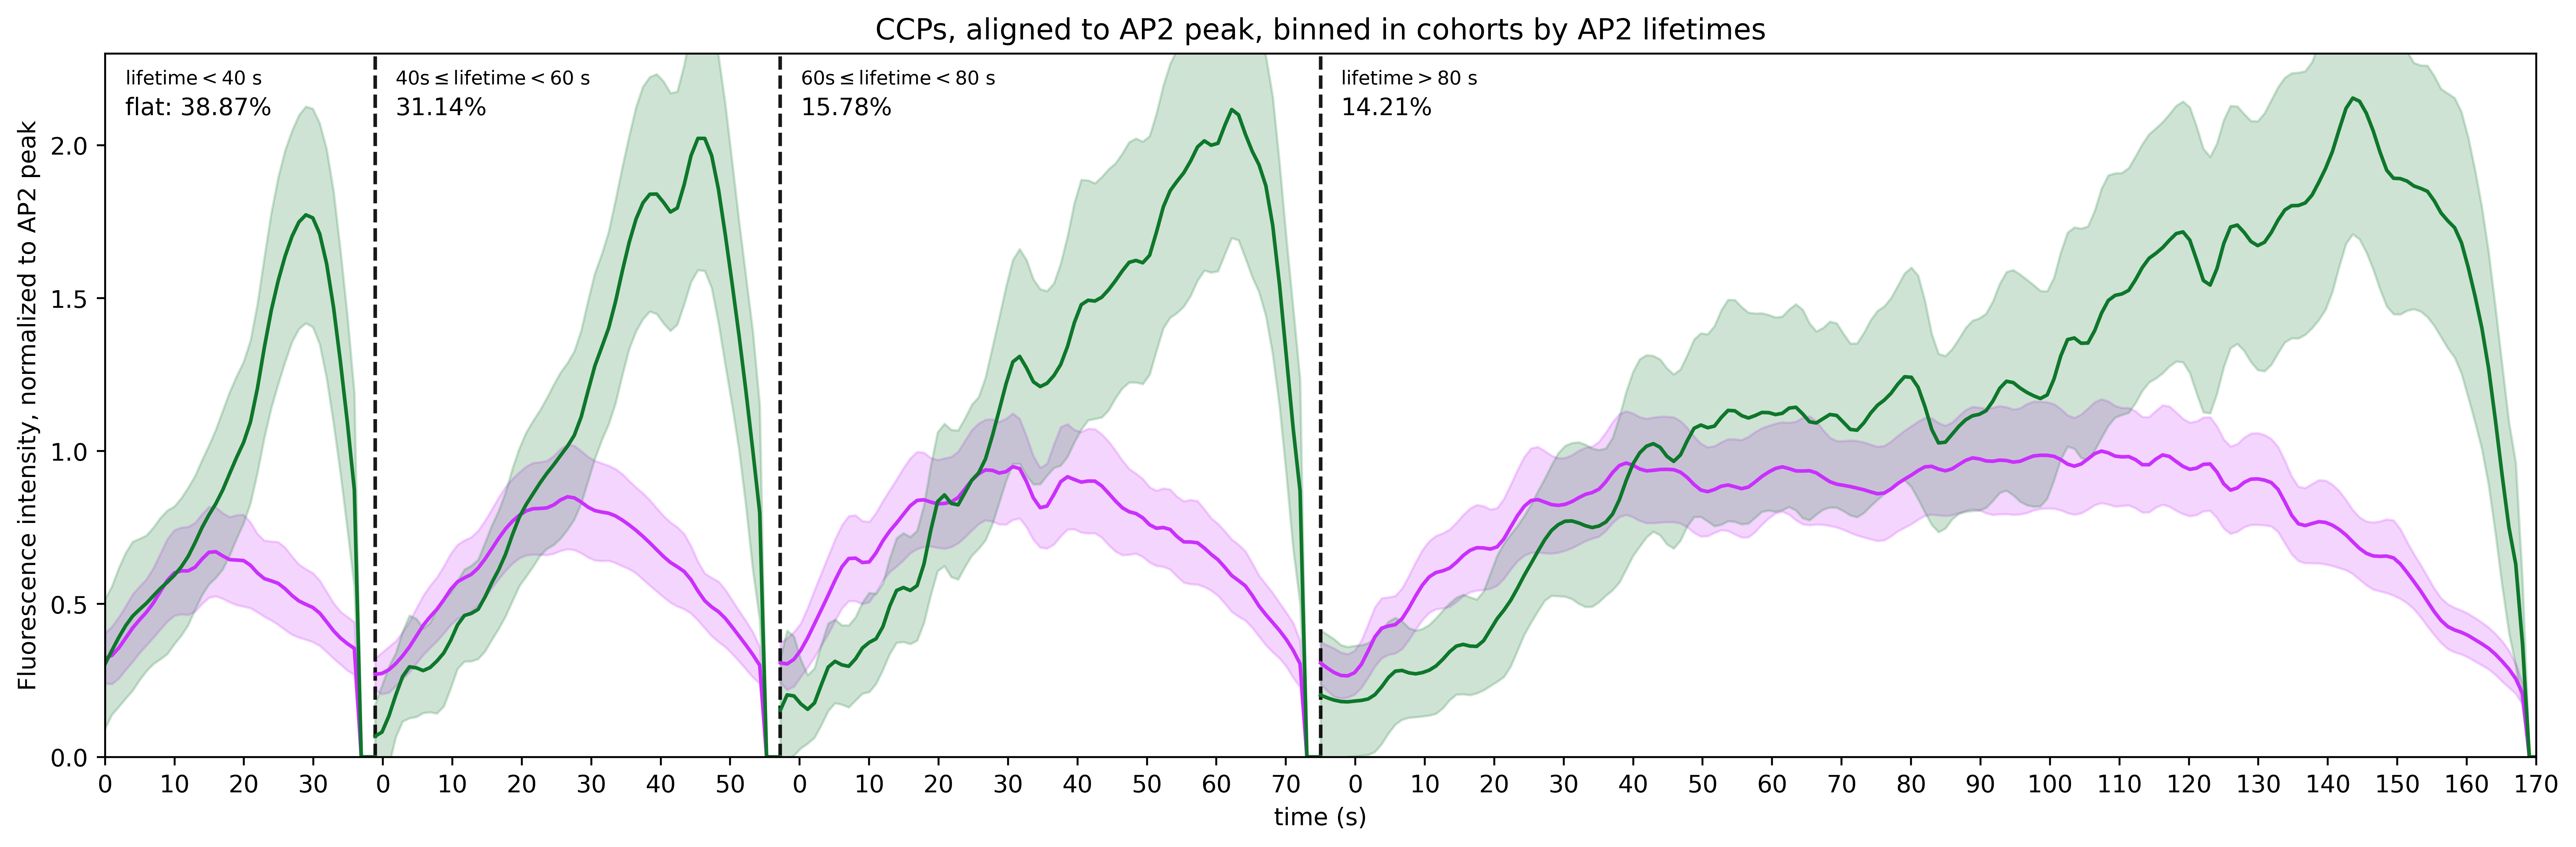

In [33]:
##change vals_for_renormalization to the highest value that appears in max_val

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))

num_in_cohorts, offsets = plot_separated_cohorts_renormalized(axes,
                                    [channel_amplitudes_cont_1],
                                    cohorts,
                                    [['#CA30FC', '#0E772B']],
                                    vals_for_normalization = 351.7506105313033, 
                                    framerate=2)

text_horizontal_shifts = 3
text_percentage_y = 2.1
text_bounds_y = 2.2

labels_for_sizes = ['flat: ']
for shift_idx, num_in_cohort in enumerate(num_in_cohorts):
    for i in range(len(cohorts)):
        if i==0:
            if shift_idx==0:
                axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
            axes.text(text_horizontal_shifts, text_percentage_y-shift_idx*0.1, labels_for_sizes[shift_idx] + "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
        elif i==len(cohorts)-1:
            if shift_idx==0:
                axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
            axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y-shift_idx*0.1, "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
        else:
            if shift_idx==0:
                axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
            axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y-shift_idx*0.1, "{:.2f}".format(100*num_in_cohort[i]/np.sum(num_in_cohort)) + '%')
            
x_labels = []
num_ticks = 0
for cohort in cohorts:
    x_labels+=list(range(0,cohort[1]-10+1,10))
    num_ticks += int(cohort[1]/10)+1
axes.set_xticks(np.linspace(0,360,len(x_labels)), minor=False)
axes.set_xticklabels(x_labels, minor=False)
axes.set_xlabel('time (s)')
axes.set_ylabel('Fluorescence intensity, normalized to AP2 peak')
axes.set_title('CCPs, aligned to AP2 peak, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])
axes.set_ylim([0,2.3])
plt.tight_layout()

#plt.savefig('insert save name here') 